In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from helper_functions import calibration_curves
sns.set_theme(
    context="talk",
    style="ticks",
    rc={"font.sans-serif": "Arial"},
    font_scale=1.2,
)

In [33]:
# train_set = "mnist"
train_set = "mura"

results_folder = f"../../results/{train_set}"
figure_folder = "../../reports/figures"

# eval_datasets = ["mnist", "svhn"]
eval_datasets = ["mura"]

type_dict = {
    "radial": {"color": "#4E79A7", "style": "solid"},
    "radial_200": {"color": "#4E79A7", "style": "dotted"},
    "radial_200_lowlr": {"color": "#4E79A7", "style": "dashed"},
    "meanfield": {"color": "#F28E2B", "style": "dotted"},
    "laplace": {"color": "#59A14F", "style": "dashed"},
    "lowrank": {"color": "#B6992D", "style": "dashdot"},
    "ml": {"color": "#499894", "style": "solid"},
    "map": {"color": "#E15759", "style": "solid"},
    "ensemble_5": {"color": "#BAB0AC", "style": "solid"},
    "ensemble_10": {"color": "#79706E", "style": "solid"},
    "multiswag_5": {"color": "#D37295", "style": "solid"},
    "multiswag_10": {"color": "#FABFD2", "style": "solid"},
}

types = [
    "ensemble_5",
    "ensemble_10",
    "multiswag_5",
    "multiswag_10",
    "radial",
    "radial_200",
    "radial_200_lowlr",
    "meanfield",
    "lowrank",
    "laplace",
    "ml",
    "map",
]

# train_results = []
# for type in types:
#     with open(f"{results_folder}/{type}.pkl", "rb") as f:
#         data = pickle.load(f)
#         data = {k:v for k,v in data.items() if not 'eval' in k}
#         train_results.append(data)
# train_results = pd.DataFrame.from_dict(train_results)
# train_results.insert(0, "Type", types)


results = pd.DataFrame()
for dataset in eval_datasets:

    df = []
    for type in types:
        with open(f"{results_folder}/{type}.pkl", "rb") as f:
            data = pickle.load(f)[f"eval_{dataset}"]
            df.append(data)
    df = pd.DataFrame.from_dict(df)
    df.insert(0, "Type", types)
    results = pd.concat([results, df])

results = results.rename(columns={
    "Average confidence": "Avg. Conf.",
    "Average confidence when wrong": "Avg. Conf. -",
    "Average confidence when right": "Avg. Conf. +",
})

# Ensembles

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
0,ensemble_5,mura,-0.561425,0.709415,0.938018,0.650341,0.491456,0.715423,0.059197
1,ensemble_10,mura,-0.558677,0.715984,0.939427,0.643597,0.485155,0.706447,0.072387


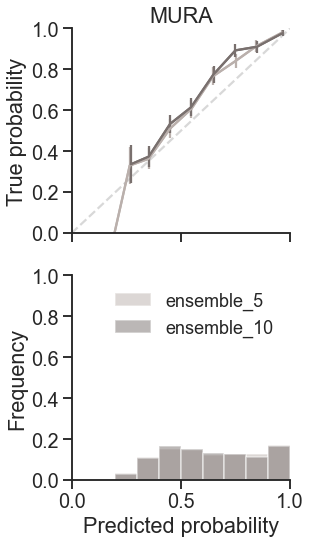

In [34]:
bins = 10

types = [
    "ensemble_5",
    "ensemble_10",
]

fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, sharex="all", sharey="all", figsize=(5*len(eval_datasets),8))
for i, dataset in enumerate(eval_datasets):
    ax_curve = ax[0, i] if len(eval_datasets) > 1 else ax[0]
    ax_hist = ax[1, i] if len(eval_datasets) > 1 else ax[1]
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)

        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece

        line, = ax_curve.plot(prob_pred, prob_true, label=f"{type}", c=type_dict[type]["color"], linestyle=type_dict[type]["style"])
        ax_curve.errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color(), linestyle=type_dict[type]["style"])

        ax_hist.bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5, label=f"{type}")

    ls = np.linspace(0, 1)
    ax_curve.plot(ls, ls, "--", color="grey", alpha=0.3)
    ax_curve.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title=dataset.upper(),
    )
    ax_hist.set(
        xlim=(0, 1),
        ylim=(0, 1),
    )
    if i == 0:
        ax_curve.set(
            ylabel="True probability",
        )
        ax_hist.set(
            xlabel="Predicted probability",
            ylabel="Frequency",
        )
    if i == len(eval_datasets)-1:
        ax_hist.legend(frameon=False, fontsize="small")
        ax_hist.set(
            xlabel="Predicted probability",
        )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/{train_set.capitalize()}Ensembles.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

# Guides

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
5,radial_200,mura,1.095201,0.591179,0.888919,0.571988,0.458243,0.650646,0.022924
7,meanfield,mura,1.766220,0.351892,0.684228,0.393481,0.345995,0.480940,0.047952
8,lowrank,mura,1.606285,0.371598,0.749881,0.358181,0.298902,0.458426,0.023085
9,laplace,mura,1.675914,0.383485,0.700265,0.403400,0.348647,0.491424,0.048065


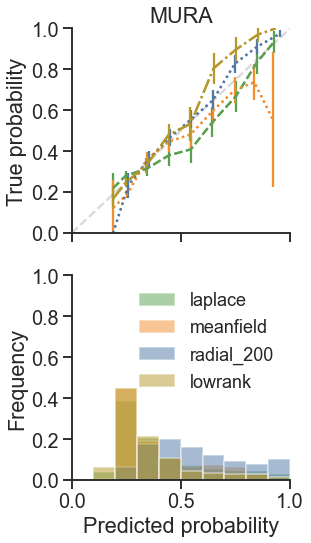

In [40]:
bins = 10

types = [
    # "ml",
    # "map",
    "laplace",
    "meanfield",
    # "radial",
    "radial_200",
    # "radial_200_lowlr",
    "lowrank",
]


fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, sharex="all", sharey="all", figsize=(5*len(eval_datasets),8))
for i, dataset in enumerate(eval_datasets):
    ax_curve = ax[0, i] if len(eval_datasets) > 1 else ax[0]
    ax_hist = ax[1, i] if len(eval_datasets) > 1 else ax[1]
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)

        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece

        line, = ax_curve.plot(prob_pred, prob_true, label=f"{type}", c=type_dict[type]["color"], linestyle=type_dict[type]["style"])
        ax_curve.errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color(), linestyle=type_dict[type]["style"])

        ax_hist.bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5, label=f"{type}")

    ls = np.linspace(0, 1)
    ax_curve.plot(ls, ls, "--", color="grey", alpha=0.3)
    ax_curve.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title=dataset.upper(),
    )
    ax_hist.set(
        xlim=(0, 1),
        ylim=(0, 1),
    )
    if i == 0:
        ax_curve.set(
            ylabel="True probability",
        )
        ax_hist.set(
            xlabel="Predicted probability",
            ylabel="Frequency",
        )
    if i == len(eval_datasets)-1:
        ax_hist.legend(frameon=False, fontsize="small")
        ax_hist.set(
            xlabel="Predicted probability",
        )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/{train_set.capitalize()}VI.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

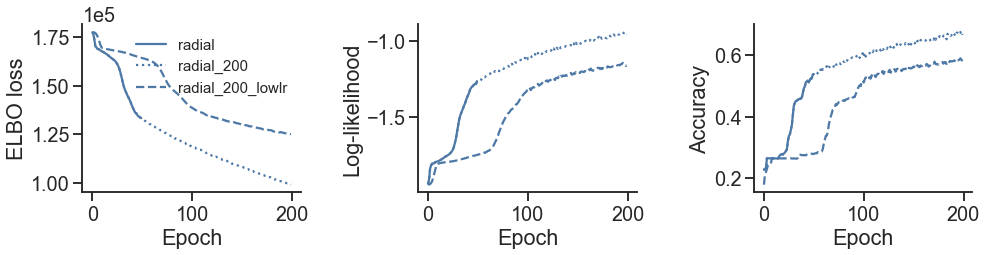

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
for guide in [
    # "meanfield",
    # "lowrank",
    "radial",
    "radial_200",
    "radial_200_lowlr",
]:
    with open(f"{results_folder}/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        epochs = np.arange(len(data["Training ELBO"]))
        ax[0].plot(epochs, data["Training ELBO"].squeeze(), label=guide, c=type_dict[guide]["color"], linestyle=type_dict[guide]["style"])
        ax[1].plot(epochs, data["Validation log-likelihood"].squeeze(), label=guide, c=type_dict[guide]["color"], linestyle=type_dict[guide]["style"])
        ax[2].plot(epochs, data["Validation accuracy"].squeeze(), label=guide, c=type_dict[guide]["color"], linestyle=type_dict[guide]["style"])
ax[0].set(
    xlabel="Epoch",
    ylabel="ELBO loss",
)
ax[1].set(
    xlabel="Epoch",
    ylabel="Log-likelihood",
)
ax[2].set(
    xlabel="Epoch",
    ylabel="Accuracy",
)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0].legend(frameon=False, fontsize="x-small")

fig.tight_layout()
sns.despine(fig)

# MultiSWAG

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
2,multiswag_5,mura,-0.591607,0.718799,0.940862,0.684732,0.514897,0.751174,0.034190
3,multiswag_10,mura,-0.589532,0.720676,0.942285,0.678781,0.507247,0.745265,0.042017


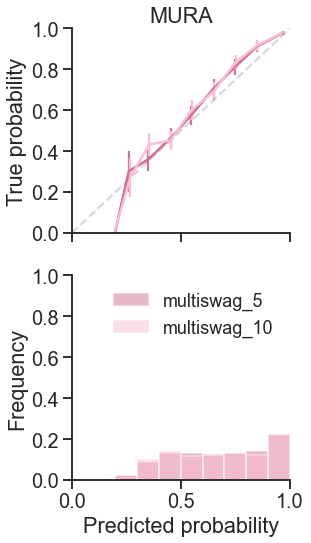

In [37]:
bins = 10

types = [
    "multiswag_5",
    "multiswag_10",
]

fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, sharex="all", sharey="all", figsize=(5*len(eval_datasets),8))
for i, dataset in enumerate(eval_datasets):
    ax_curve = ax[0, i] if len(eval_datasets) > 1 else ax[0]
    ax_hist = ax[1, i] if len(eval_datasets) > 1 else ax[1]
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)

        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece

        line, = ax_curve.plot(prob_pred, prob_true, label=f"{type}", c=type_dict[type]["color"], linestyle=type_dict[type]["style"])
        ax_curve.errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color(), linestyle=type_dict[type]["style"])

        ax_hist.bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5, label=f"{type}")

    ls = np.linspace(0, 1)
    ax_curve.plot(ls, ls, "--", color="grey", alpha=0.3)
    ax_curve.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title=dataset.upper(),
    )
    ax_hist.set(
        xlim=(0, 1),
        ylim=(0, 1),
    )
    if i == 0:
        ax_curve.set(
            ylabel="True probability",
        )
        ax_hist.set(
            xlabel="Predicted probability",
            ylabel="Frequency",
        )
    if i == len(eval_datasets)-1:
        ax_hist.legend(frameon=False, fontsize="small")
        ax_hist.set(
            xlabel="Predicted probability",
        )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/{train_set.capitalize()}MultiSwag.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

In [38]:
results.drop(["Test targets", "Test probabilities"], axis=1)

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
0,ensemble_5,mura,-0.561425,0.709415,0.938018,0.650341,0.491456,0.715423,0.059197
1,ensemble_10,mura,-0.558677,0.715984,0.939427,0.643597,0.485155,0.706447,0.072387
2,multiswag_5,mura,-0.591607,0.718799,0.940862,0.684732,0.514897,0.751174,0.034190
3,multiswag_10,mura,-0.589532,0.720676,0.942285,0.678781,0.507247,0.745265,0.042017
4,radial,mura,1.453502,0.437598,0.795566,0.475476,0.405818,0.565001,0.061835
5,radial_200,mura,1.095201,0.591179,0.888919,0.571988,0.458243,0.650646,0.022924
6,radial_200_lowlr,mura,1.313669,0.493275,0.834879,0.516654,0.431716,0.603908,0.044365
7,meanfield,mura,1.766220,0.351892,0.684228,0.393481,0.345995,0.480940,NaN
8,lowrank,mura,1.606285,0.371598,0.749881,0.358181,0.298902,0.458426,NaN
9,laplace,mura,1.675914,0.383485,0.700265,0.403400,0.348647,0.491424,NaN


In [39]:
print(
results\
    .drop(["Test targets", "Test probabilities"], axis=1)\
    .to_latex(index=False, float_format="%.4f")
)

\begin{tabular}{llrrrrrrr}
\toprule
            Type & Evaluated on &     NLL &  Accuracy &  AUROC &  Avg. Conf. &  Avg. Conf. - &  Avg. Conf. + &    ECE \\
\midrule
      ensemble\_5 &         mura & -0.5614 &    0.7094 & 0.9380 &      0.6503 &        0.4915 &        0.7154 & 0.0592 \\
     ensemble\_10 &         mura & -0.5587 &    0.7160 & 0.9394 &      0.6436 &        0.4852 &        0.7064 & 0.0724 \\
     multiswag\_5 &         mura & -0.5916 &    0.7188 & 0.9409 &      0.6847 &        0.5149 &        0.7512 & 0.0342 \\
    multiswag\_10 &         mura & -0.5895 &    0.7207 & 0.9423 &      0.6788 &        0.5072 &        0.7453 & 0.0420 \\
          radial &         mura &  1.4535 &    0.4376 & 0.7956 &      0.4755 &        0.4058 &        0.5650 & 0.0618 \\
      radial\_200 &         mura &  1.0952 &    0.5912 & 0.8889 &      0.5720 &        0.4582 &        0.6506 & 0.0229 \\
radial\_200\_lowlr &         mura &  1.3137 &    0.4933 & 0.8349 &      0.5167 &        0.4317 &       

C:\Users\s174433\AppData\Local\Temp\ipykernel_6776\2838641838.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results\


,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,Test targets,Test probabilities,ECE
4,radial_200,mura,1.095201,0.591179,0.888919,0.571988,0.458243,0.650646,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[[0.30161354, 0.05432974, 0.058231603, 0.02122...",0.022924
